This notebook is to test different ansatz for VarQITE algorithm. We are using the VarQITE algorithm to find the eigenvalues of a Tight Binding Hamiltonian. We are currently testing an ansatz which creates superposition of states of a particular sub_space (such that number of ones in all the superposed states is same). We then expect this ansatz to give the lowest eigenvalue of that sub-space.  

For Example, for a 5 qubit system it would look like this :  

$$|{\psi \rangle = a_0| 10001\rangle + a_1|10010 \rangle + a_2|10100 \rangle + a_3| 11000\rangle + a_4|01001 \rangle + a_5| 01010\rangle + a_6| 01100\rangle + a_7|00101 \rangle + a_8| 00110\rangle + a_9|00011 \rangle }$$  

for number of ones = 2 or  

$$| \psi \rangle = a_0|10000 \rangle + a_1|01000 \rangle + a_2| 00100\rangle + a_3| 00010\rangle + a_4| 00001 \rangle$$   
for number of ones = 1  
- Run this notebook for different ansatz (currently : su2, easy, easy3)

In [1]:
import numpy as np
from qiskit import *
from qiskit.circuit import Parameter
from qiskit.quantum_info import SparsePauliOp, Statevector
from tabulate import tabulate
from itertools import combinations
from qiskit.circuit.library import EfficientSU2
import math
import time
from qiskit.circuit.library import EfficientSU2
from qiskit.algorithms.time_evolvers.variational import ImaginaryMcLachlanPrinciple
from qiskit.algorithms import TimeEvolutionProblem
from qiskit.algorithms import VarQITE
from qiskit.primitives import Estimator
from qiskit.quantum_info import Statevector
from qiskit.algorithms import SciPyImaginaryEvolver
import pylab
from qiskit.algorithms.gradients import ReverseEstimatorGradient, ReverseQGT
from qiskit.circuit.library import RYGate
import matplotlib.pyplot as plt

In [2]:
def tb0_JW(N,e,t) : 
    strings = []
    opt = SparsePauliOp.from_sparse_list([("I", [0], 0)], num_qubits=N)  
    for k in range(N) : 
        a0='I'*(N)
        a1 = 'I'*(k)+'Z' +'I'*(N-k-1)

        b0='I'*N
        b0_list = list(b0)
        b0_list[k] = 'X'
        b0_list[(k+1)%N] = 'X'
        new_b0 = ''.join(b0_list)

        b1='I'*N
        b1_list = list(b0)
        b1_list[k] = 'Y'
        b1_list[(k+1)%N] = 'Y'
        new_b1 = ''.join(b1_list)

        strings.append([a0,a1,new_b0,new_b1])
        val = 1
        if N==2 and k==1 : 
            val = 0
        opt += SparsePauliOp.from_list([(a0, 0.5*e[k]), (a1, -0.5*e[k]),(new_b0, 0.5*t*val),(new_b1, 0.5*t*val)])
    return opt  

def spinless_basis(N,r) : 
    basis_set = []
    lattice = list(range(N))
    places = list(combinations(lattice, r))
    for combination in places : 
        basis = [False] *N
        for index in combination : 
            basis[index] = True 
        basis_set.append(basis)
    return basis_set

In [3]:
N=2
e=[1]*N
t=7
H_op = tb0_JW(N,e,t)

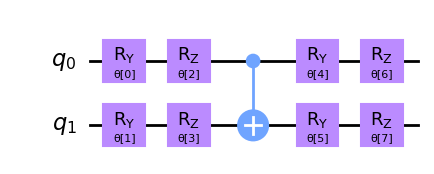

In [4]:
#This finds the right results for less number of qubits and takes a lot of time 
su2 = EfficientSU2(H_op.num_qubits, reps=1)
su2.decompose().draw('mpl')
#print(su2.parameters)


In [5]:
def scs_param(n,l,var,param) : 

    circ = QuantumCircuit(n)
    circ.cx(-2,-1)
    circ.cry(param[var],-1,-2)
    var+=1
    circ.cx(-2,-1)

    for i in range(l-1) : 
        circ.cx(-3-i,-1)
        ccry = RYGate(param[var]).control(2,label=None)
        var+=1
        circ.append(ccry,[-1,-2-i,-3-i])
        circ.cx(-3-i,-1)
    return circ, var

def dicke_param(n,k) : 
    pairs = []
    for a in range(n,k,-1) : 
        pairs.append([a,k])
    for a in range(k,1,-1) : 
        pairs.append([a,a-1])

    num_angles = int(3*(n-k) + k*(k-1)/2)
    param = [Parameter(f"angle_{i+1}") for i in range(num_angles)]

    dk_circ = QuantumCircuit(n)
    dk_circ.x(range(-1,-k-1,-1))
    var=0
    for pair in pairs : 
        new_circ,new_var = scs_param(pair[0],pair[1],var,param)
        var = new_var
        dk_circ.append(new_circ, range(pair[0]))
    return dk_circ

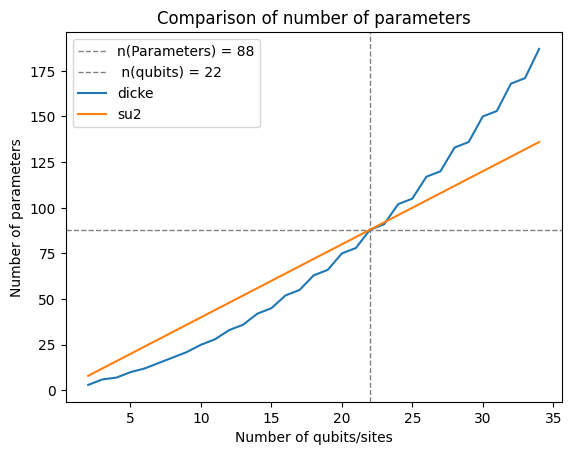

In [6]:
#Comparison of paramters 
param_dicke = []
param_su2 = []
max = 35
for n in range(2,max) : 
    k = n//2
    param_dicke.append(int(3*(n-k) + k*(k-1)/2))
    param_su2.append(4*n)
    if int(3*(n-k) + k*(k-1)/2) == 4*n : 
        n_inter = n 
        param_inter = 4*n
plt.axhline(y=param_inter, color='black', linestyle='--', linewidth=1, alpha=0.5, 
            label=f'n(Parameters) = {param_inter}')
plt.axvline(x=n_inter, color='black', linestyle='--', linewidth=1, alpha=0.5, 
            label=f' n(qubits) = {n_inter}')   
plt.plot(range(2,max),param_dicke, label='dicke')
plt.plot(range(2,max),param_su2, label='su2')
plt.xlabel('Number of qubits/sites')
plt.ylabel('Number of parameters')
plt.title('Comparison of number of parameters')
plt.legend()

In [7]:
eig,vec = np.linalg.eig(H_op.to_matrix())
new_vec = list(zip(*vec))

In [8]:
#print(eig)
eigstates = []
for i,x in enumerate(eig) : 
    if np.round(x) == np.round(min(eig)) : 
        eigstates.append(new_vec[i])
print("Minimum eigenvalue=", min(eig))
print("Eigenstates with lowest eigenvalue : ")
for state in eigstates : 
    print([np.round(x,3) for x in np.asarray(state)])


Minimum eigenvalue= (-6+0j)
Eigenstates with lowest eigenvalue : 
[(-0-0j), (-0.707-0j), (0.707+0j), (-0-0j)]


{ParameterVectorElement(θ[0]): 1, ParameterVectorElement(θ[1]): 1, ParameterVectorElement(θ[2]): 1, ParameterVectorElement(θ[3]): 1, ParameterVectorElement(θ[4]): 1, ParameterVectorElement(θ[5]): 1, ParameterVectorElement(θ[6]): 1, ParameterVectorElement(θ[7]): 1}
Elapsed time:  83.67532014846802  seconds for ansatz a_i = 0
Rounded statevector : 
[(-0.002-0.006j), (-0.439+0.554j), (0.439-0.555j), (-0.005-0.002j)]
Overlap with exact staevector =  [(1-1j)]
Estimated Lowest Eigenvalue = -5.9995009323895445
Exact lowest eigenvalue found :  -6.0


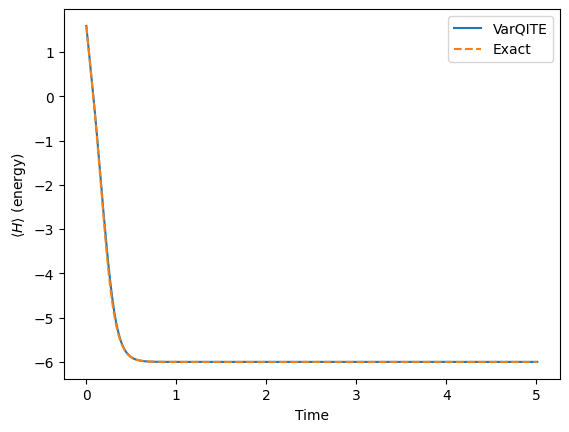

{Parameter(angle_1): 1}
Elapsed time:  15.35320258140564  seconds for ansatz a_i = 1
Rounded statevector : 
[0j, (-0.707+0j), (0.707+0j), 0j]
Overlap with exact staevector =  [(1+0j)]
Estimated Lowest Eigenvalue = -6.0
Exact lowest eigenvalue found :  -6.000000000000002


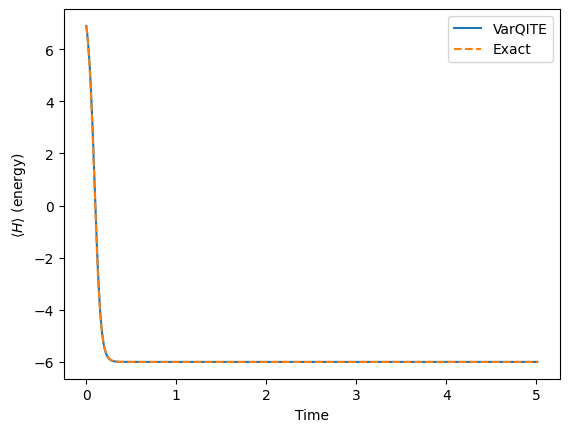

In [9]:
ansatz_list = [su2,dicke_param(N,N//2)]
backend = Aer.get_backend('statevector_simulator')

for a_i,ansatz in enumerate(ansatz_list) : 
    init_param_values={}
    for i in range(len(ansatz.parameters)):
        init_param_values[ansatz.parameters[i]]=1
    print(init_param_values)
    
    var_principle = ImaginaryMcLachlanPrinciple()
    
    exp_time = 5.0
    aux_ops = [H_op]
    evolution_problem = TimeEvolutionProblem(H_op, exp_time, aux_operators=aux_ops)
    
    start_time = time.time()
    var_principle = ImaginaryMcLachlanPrinciple(qgt = ReverseQGT() , gradient = ReverseEstimatorGradient())
    evolution_problem = TimeEvolutionProblem(H_op, exp_time, aux_operators=aux_ops)
    var_qite = VarQITE(ansatz, init_param_values, var_principle, Estimator())
    evolution_result_eff = var_qite.evolve(evolution_problem)
    end_time = time.time()
    elapsed_time = end_time - start_time

    print("Elapsed time: ", elapsed_time, " seconds for ansatz a_i =",a_i)
    
    eff_circ = evolution_result_eff.evolved_state
    
    eff_job = execute(eff_circ, backend)
    eff_result = eff_job.result()
    eff_statevector = eff_result.get_statevector()
    
    sum_of_squares = (np.array(eff_statevector).conj() @ np.array(eff_statevector)).real
    norm_state = eff_statevector/np.sqrt(sum_of_squares)
    final_sv = [np.round(x,3) for x in np.asarray(norm_state)]
    print("Rounded statevector : ")
    print(final_sv)
    
    overlap_list =[]
    for state in eigstates : 
        overlap_list.append(np.round(np.dot(state,final_sv)))
    print("Overlap with exact staevector = ",overlap_list)
    
    h_exp_val = np.array([ele[0][0] for ele in evolution_result_eff.observables])
    print("Estimated Lowest Eigenvalue =", h_exp_val[-1])
    
    #Classical simulation
    init_state = Statevector(ansatz.assign_parameters(init_param_values))
    
    evolution_problem = TimeEvolutionProblem(H_op, exp_time, initial_state=init_state, 
                                             aux_operators=aux_ops)
    exact_evol = SciPyImaginaryEvolver(num_timesteps=501)
    sol = exact_evol.evolve(evolution_problem)
    
    exact_h_exp_val = sol.observables[0][0].real
    print("Exact lowest eigenvalue found : ",exact_h_exp_val[-1]) 
    
    times = evolution_result_eff.times
    pylab.plot(times, h_exp_val, label= "VarQITE")
    pylab.plot(times, exact_h_exp_val , label= "Exact",  linestyle='--')
    pylab.xlabel("Time")
    pylab.ylabel(r"$\langle H \rangle$ (energy)")
    pylab.legend(loc="upper right");
    plt.pause(1)


### References  
1. [Variational Quantum Time Evolution - Qiskit Documentation](https://qiskit.org/documentation/tutorials/algorithms/11_VarQTE.html)  
2. [Yuan et al. Quantum 3, 191](https://quantum-journal.org/papers/q-2019-10-07-191/)  
3. [Dicke States](https://arxiv.org/abs/1904.07358)  
